# DGA Domain Detection: Unveiling Malicious Activity in the Digital Realm

Welcome to my DGA Domain Detection Jupyter Notebook! This notebook showcases my innovative approach to detecting and classifying Domain Generation Algorithm (DGA) domains, a technique commonly employed by malware to evade detection and maintain communication with command-and-control servers.

In today's ever-evolving cyber threat landscape, identifying and mitigating the risks associated with DGA domains is crucial for maintaining a robust security posture. This notebook demonstrates a powerful solution that leverages advanced data analysis, machine learning, and domain expertise to effectively detect and differentiate between legitimate and DGA-generated domains.

## Key Features and Highlights

- **Comprehensive Dataset:** I utilize a diverse dataset comprising both legitimate and DGA domains, enabling the development of a well-rounded and accurate detection model.
- **Feature Engineering:** Through meticulous feature engineering techniques, I extract meaningful attributes such as domain length, entropy, and character n-gram frequencies, empowering the model to discern patterns and anomalies indicative of DGA domains.
- **Machine Learning Powered:** By harnessing the power of machine learning algorithms, specifically the Random Forest classifier, I build a sophisticated model capable of accurately classifying domains as either legitimate or DGA-generated.
- **Insightful Visualizations:** The notebook incorporates captivating visualizations that provide deep insights into the characteristics and distributions of legitimate and DGA domains, enhancing understanding and facilitating data-driven decision-making.
- **Reproducible and Extensible:** The codebase is well-documented, modular, and follows best practices, ensuring reproducibility and enabling seamless extensibility for future enhancements and customizations.

## Why It Matters

In the realm of cybersecurity, proactively identifying and mitigating threats is paramount. DGA domains pose a significant risk by enabling malware to establish resilient communication channels and evade traditional detection mechanisms. By leveraging the power of data science and machine learning, this notebook equips security professionals with a potent tool to detect and thwart DGA-based threats effectively.

Whether you are a seasoned security researcher, a data scientist passionate about cybersecurity, or a curious learner eager to explore cutting-edge techniques, this notebook offers valuable insights and practical knowledge. It serves as a testament to the application of data-driven approaches in safeguarding digital assets and combating evolving cyber threats.

Join me on this exciting journey as I delve into the world of DGA domain detection and unravel the intricacies of protecting our digital landscape. Together, let us fortify the defenses against malicious actors and contribute to a safer online ecosystem.

Get ready to embark on a captivating exploration of DGA domain detection, where data science meets cybersecurity!

In [1]:
import pandas as pd
import numpy as np
import math
import tldextract
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle

import sklearn.ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sklearn.feature_extraction
import matplotlib.pyplot as plt
import seaborn as sns

/Users/winsome/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#Extract domain from URI
def domain_extract(uri):
    ext = tldextract.extract(uri)
    return ext.domain if ext.suffix else np.nan

#Calculate entropy of a string
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

In [3]:
# Read the DGA domains dataset from a CSV file
dga_dataframe = pd.read_csv('dga-domains.csv')
# Remove rows with missing values
dga_dataframe = dga_dataframe.dropna()
# Remove duplicate rows
dga_dataframe = dga_dataframe.drop_duplicates()
# Assign the class label 'dga' to all rows in the DGA domains dataset
dga_dataframe['class'] = 'dga'

# Read the Umbrella top 1 million domains dataset from a CSV file
umbrella_top_1m = pd.read_csv('umbrella-domains.csv')
# Extract the domain name from each URL using the domain_extract function
umbrella_top_1m['domain'] = [ domain_extract(uri) for uri in umbrella_top_1m['domain']]
# Remove rows with missing values
umbrella_top_1m = umbrella_top_1m.dropna()
# Remove duplicate rows
umbrella_top_1m = umbrella_top_1m.drop_duplicates()
# Assign the class label 'legit' to all rows in the Umbrella domains dataset
umbrella_top_1m['class'] = 'legit'

# Read the dictionary words dataset from a CSV file
word_dataframe = pd.read_csv('words.csv')
# Filter the dataset to include only rows where the 'word' column contains alphabetic characters
word_dataframe = word_dataframe[word_dataframe['word'].map(lambda x: str(x).isalpha())]
# Apply string transformations to each value in the dataset (strip whitespace and convert to lowercase)
word_dataframe = word_dataframe.applymap(lambda x: str(x).strip().lower())
# Remove rows with missing values
word_dataframe = word_dataframe.dropna()
# Remove duplicate rows
word_dataframe = word_dataframe.drop_duplicates()

# Concatenate the Umbrella domains dataset and the DGA domains dataset into a single DataFrame
all_domains = pd.concat([umbrella_top_1m, dga_dataframe], ignore_index=True)
# Calculate the length of each domain and add it as a new column 'length'
all_domains['length'] = [len(str(x)) for x in all_domains['domain']]
# Filter the dataset to include only domains with a length greater than 6 characters
all_domains = all_domains[all_domains['length'] > 6]
# Calculate the entropy of each domain and add it as a new column 'entropy'
all_domains['entropy'] = [entropy(x) for x in all_domains['domain']]

# Create a CountVectorizer for character n-grams (3 to 5 characters) from the Umbrella domains
umbrella_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-4, max_df=1.0)
# Fit the CountVectorizer to the Umbrella domains and transform them into a counts matrix
counts_matrix = umbrella_vc.fit_transform(umbrella_top_1m['domain'])
# Calculate the logarithm (base 10) of the sum of counts for each n-gram feature
umbrella_counts = np.log10(counts_matrix.sum(axis=0).getA1())

# Create a CountVectorizer for character n-grams (3 to 5 characters) from the dictionary words
dict_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-5, max_df=1.0)
# Fit the CountVectorizer to the dictionary words and transform them into a counts matrix
counts_matrix = dict_vc.fit_transform(word_dataframe['word'])
# Calculate the logarithm (base 10) of the sum of counts for each n-gram feature
dict_counts = np.log10(counts_matrix.sum(axis=0).getA1())

# Transform the domains using the Umbrella CountVectorizer and multiply the counts by the logarithmic counts
all_domains['umbrella_grams'] = umbrella_counts * umbrella_vc.transform(all_domains['domain']).T
# Transform the domains using the dictionary CountVectorizer and multiply the counts by the logarithmic counts
all_domains['word_grams'] = dict_counts * dict_vc.transform(all_domains['domain']).T

# Extract the features (length, entropy, umbrella_grams, word_grams) from the DataFrame and convert them to a numpy array
X = all_domains[['length', 'entropy', 'umbrella_grams', 'word_grams']].to_numpy()
# Extract the class labels from the DataFrame and convert them to a numpy array
y = np.array(all_domains['class'].tolist())

/var/folders/qk/v84cyynn51x8q0my0q641rl40000gn/T/ipykernel_53331/1534671599.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  word_dataframe = word_dataframe.applymap(lambda x: str(x).strip().lower())


In [4]:
# This code snippet trains a machine learning model called a Random Forest Classifier for
# the task of classifying domain names as either legitimate or malicious (DGA-based).

# The first line creates an instance of the RandomForestClassifier class from the scikit-learn library,
# specifying that the model should use an ensemble of 20 decision trees (n_estimators=20).

# The second line splits the available data into training and testing sets. The data is contained in two variables:
#   - X: This variable contains the features or characteristics of the domain names, such as length, entropy,
#        n-gram matches, etc.
#   - y: This variable contains the corresponding labels or classes for each domain name (either 'legit' or 'dga').

# The train_test_split function from scikit-learn is used to split the data into:
#   - X_train: Features of the domain names used for training the model
#   - X_test: Features of the domain names used for testing the model
#   - y_train: Labels of the domain names used for training the model
#   - y_test: Labels of the domain names used for testing the model

# The test_size=0.2 argument specifies that 20% of the data should be allocated to the testing set,
# and the remaining 80% will be used for training the model.

# The third line, clf.fit(X_train, y_train), trains the Random Forest Classifier model
# using the training data (X_train and y_train).

# During the training process, the Random Forest algorithm builds multiple decision trees based
# on random subsets of the features and data samples. Each tree learns patterns and
# rules for classifying domain names as legitimate or malicious based on the provided training examples.

# After training, the model can be used to make predictions on new, unseen domain names by passing
# their features (X_test) to the model's predict() method. The predicted labels can then be compared
# to the true labels (y_test) to evaluate the model's performance using metrics like accuracy, precision,
# recall, and the confusion matrix.

# The trained Random Forest Classifier model can be further fine-tuned by adjusting hyperparameters
# like the number of trees (n_estimators) or the maximum depth of each tree,
# depending on the requirements of the DGA detection task.

clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20)

In [1]:
# This code snippet uses the Random Forest Classifier model that was previously trained to
# make predictions on the test data and evaluates the model's performance using a confusion matrix.

# The first line, y_pred = clf.predict(X_test), makes predictions on the test data (X_test)
# using the trained Random Forest Classifier model (clf). The predict() method takes the features
# of the domain names in the test set (X_test) and returns the predicted labels (either 'legit' or 'dga')
# for each domain name. The predicted labels are stored in the y_pred variable.

# The second line, print(confusion_matrix(y_test, y_pred, labels=['legit', 'dga'])),
# prints the confusion matrix for the model's predictions.

# The confusion_matrix() function from scikit-learn takes three arguments:
#   - y_test: The true or actual labels of the domain names in the test set
#   - y_pred: The predicted labels made by the model
#   - labels: The unique class labels present in the data (in this case, 'legit' and 'dga')

# The confusion matrix is a table that summarizes the model's performance by comparing the predicted labels to the true labels. It has four cells:
#   - True Positives (TP): The number of malicious (DGA-based) domain names correctly classified as 'dga'
#   - False Positives (FP): The number of legitimate domain names incorrectly classified as 'dga'
#   - False Negatives (FN): The number of malicious (DGA-based) domain names incorrectly classified as 'legit'
#   - True Negatives (TN): The number of legitimate domain names correctly classified as 'legit'

# The output of the print statement will show the confusion matrix in the following format:
#     Predicted Legit  Predicted DGA
# Actual Legit       TN              FP
# Actual DGA         FN              TP

# By analyzing the values in the confusion matrix, you can evaluate the model's performance
# and identify areas for improvement. Ideally, you want high values in the True Positive (TP)
# and True Negative (TN) cells, and low values in the False Positive (FP) and False Negative (FN) cells.

# The confusion matrix provides valuable insights into the model's ability
# to correctly classify legitimate and malicious domain names, as well as
# its tendency to make false positive or false negative errors.

y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred, labels=['legit', 'dga']))

y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred, labels=['legit', 'dga']))

NameError: name 'clf' is not defined

In [6]:
# This code snippet separates the domain names in the 'all_domains' dataset
# into two separate datasets: 'dga' and 'legit', based on the 'class' column.

# The first line, cond = all_domains['class'] == 'dga', creates a boolean condition (cond)
# that checks if the value in the 'class' column of the 'all_domains' dataset is equal to 'dga'.
# This condition will be True for rows where the domain name is classified as DGA-based (malicious),
# and False for rows where the domain name is classified as legitimate.

# The second line, dga = all_domains[cond], creates a new dataset called 'dga' that
# contains only the rows from 'all_domains' where the condition 'cond' is True. In other words,
# 'dga' will contain all the DGA-based (malicious) domain names from the original dataset.

# The third line, legit = all_domains[~cond], creates another new dataset called 'legit' that
# contains only the rows from 'all_domains' where the condition '~cond' is True. The '~' symbol
# is the bitwise NOT operator, which flips the boolean values. So, '~cond' is True for rows where 'cond'
# is False, and False for rows where 'cond' is True. In this case, 'legit' will contain all the
# legitimate domain names from the original dataset.

# By separating the data into two datasets ('dga' and 'legit'), you can analyze and work with the
# legitimate and malicious domain names separately. This can be useful for various tasks, such as:

# 1. Visualizing and exploring the characteristics of legitimate and malicious domain names individually.
# 2. Training machine learning models separately on the legitimate and malicious data, or combining them
#    with different weights or techniques.
# 3. Performing data preprocessing or feature engineering steps specific to each class of domain names.
# 4. Evaluating the performance of models or algorithms on the legitimate and malicious data separately.

# Having separate datasets for legitimate and malicious domain names can provide more flexibility and control over the analysis and modeling processes, enabling you to tailor your approaches to the specific requirements of each class.

cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]

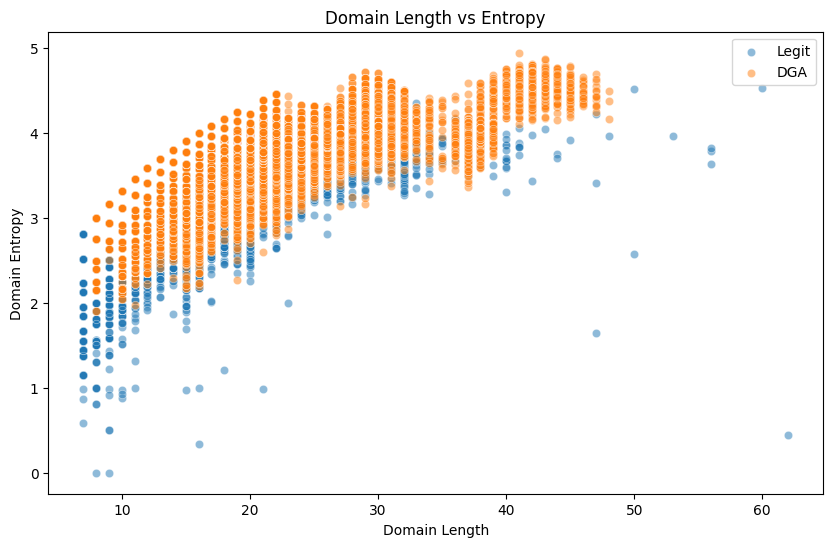

In [7]:
# Domain Length vs Entropy
#
# This graph shows the relationship between the length of a domain name (x-axis) and
# how random or unpredictable the characters in the domain name are (y-axis, called entropy).
#
# The blue dots represent legitimate domain names, and the orange dots represent domain names 
# generated by malicious software (DGA-based).
#
# If the blue and orange dots form separate clusters, it means that the length and randomness
# of the domain name can be useful for telling apart legitimate and malicious domain names.
#
# However, if the blue and orange dots overlap a lot, it suggests that additional information
# or more advanced techniques may be needed for accurate detection.
#
# By looking at the patterns and outliers (dots that don't fit the main clusters)
# in this graph, we can better understand the characteristics of legitimate and malicious domain names.
#
# This understanding can help us develop more effective ways to detect and block malicious domains.

plt.figure(figsize=(10, 6))
sns.scatterplot(data=legit, x='length', y='entropy', color='#1f77b4', alpha=0.5, label='Legit')
sns.scatterplot(data=dga, x='length', y='entropy', color='#ff7f0e', alpha=0.5, label='DGA')
plt.title('Domain Length vs Entropy')
plt.xlabel('Domain Length')
plt.ylabel('Domain Entropy')
plt.legend()
plt.show()

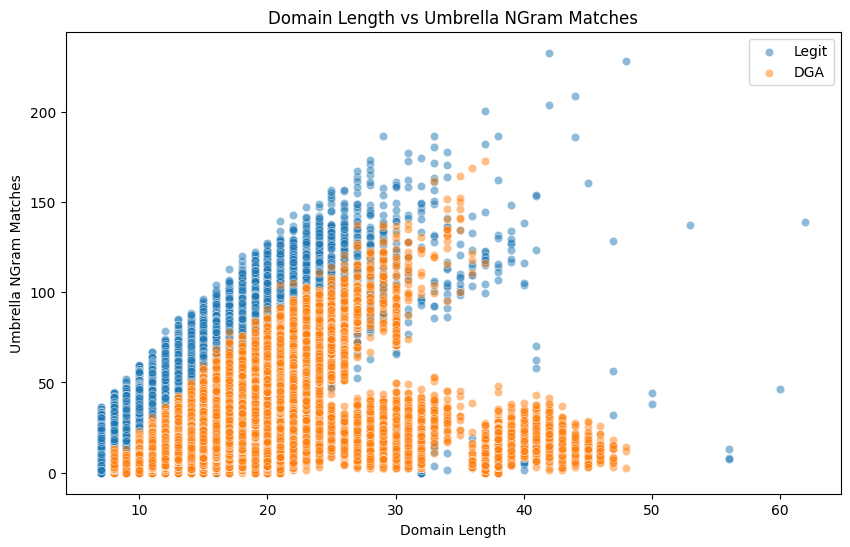

In [8]:
# Domain Length vs Umbrella NGram Matches
#
# This scatter plot visualizes the relationship between domain length and the number of n-gram matches.
#
# This graph shows the relationship between the length of a domain name (x-axis) and how many small pieces
# of the domain name (called n-grams) match with a list of known legitimate domain names (y-axis).
#
# The blue dots represent legitimate domain names, and the orange dots represent domain names generated by
# malicious software (DGA-based).
#
# If the blue and orange dots form separate clusters, it means that the number of legitimate n-gram matches,
# combined with the domain length, can be useful for telling apart legitimate and malicious domain names.
#
# However, if the blue and orange dots overlap a lot, it suggests that additional information or more
# advanced techniques may be needed for accurate detection.
#
# By looking at the patterns and outliers (dots that don't fit the main clusters) in this graph,
# we can better understand the characteristics of legitimate and malicious domain names. This understanding
# can help us develop more effective ways to detect and block malicious domains.

plt.figure(figsize=(10, 6))
sns.scatterplot(data=legit, x='length', y='umbrella_grams', color='#1f77b4', alpha=0.5, label='Legit')
sns.scatterplot(data=dga, x='length', y='umbrella_grams', color='#ff7f0e', alpha=0.5, label='DGA')
plt.title('Domain Length vs Umbrella NGram Matches')
plt.xlabel('Domain Length')
plt.ylabel('Umbrella NGram Matches')
plt.legend()
plt.show()

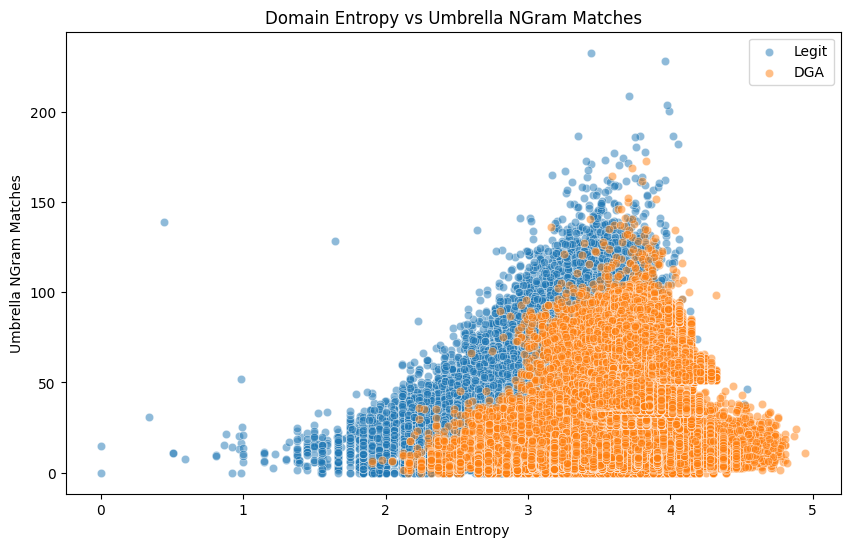

In [9]:
# Domain Entropy vs Umbrella NGram Matches
#
# This graph compares two things:
#   1. How random or unpredictable the characters in a domain name are (x-axis, called entropy)
#   2. How many small pieces of the domain name (called n-grams) match with a list of known legitimate domain names (y-axis)
#
# The blue dots represent legitimate domain names, and the orange dots represent domain names
# generated by malicious software (DGA-based).
#
# If the blue and orange dots form separate clusters, it means that the randomness of the
# domain name and the number of legitimate n-gram matches can be useful for telling apart
# legitimate and malicious domain names.
#
# However, if the blue and orange dots overlap a lot, it suggests that additional information
# or more advanced techniques may be needed for accurate detection.
#
# By looking at the patterns and outliers (dots that don't fit the main clusters) in this
# graph, we can better understand the characteristics of legitimate and malicious domain names.
# This understanding can help us develop more effective ways to detect and block malicious domains.

plt.figure(figsize=(10, 6))
sns.scatterplot(data=legit, x='entropy', y='umbrella_grams', color='#1f77b4', alpha=0.5, label='Legit')
sns.scatterplot(data=dga, x='entropy', y='umbrella_grams', color='#ff7f0e', alpha=0.5, label='DGA')
plt.title('Domain Entropy vs Umbrella NGram Matches')
plt.xlabel('Domain Entropy')
plt.ylabel('Umbrella NGram Matches')
plt.legend()
plt.show()

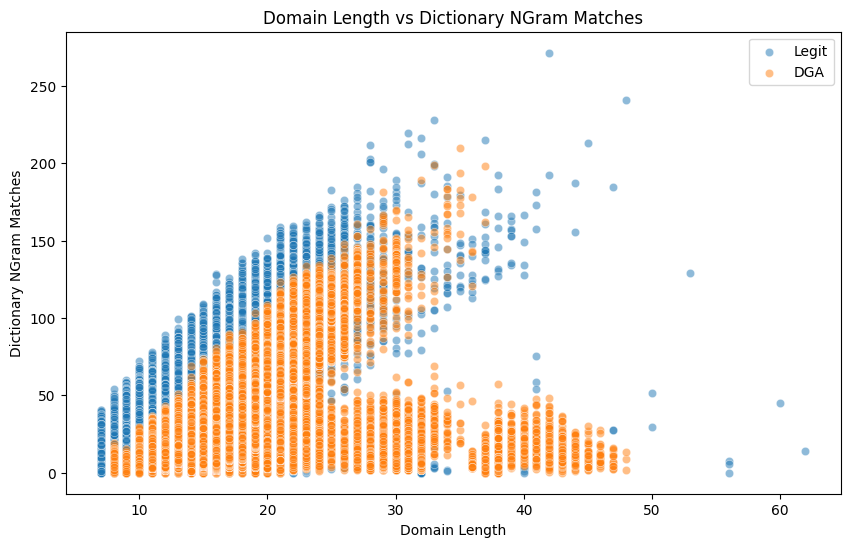

In [10]:
# Domain Length vs Dictionary NGram Matches
#
# This graph compares two things:
#   1. The length of the domain name (x-axis)
#   2. How many small pieces of the domain name (called n-grams) match with words in a dictionary (y-axis)
#
# The blue dots represent legitimate domain names, and the orange dots represent domain names
# generated by malicious software (DGA-based).
#
# If the blue and orange dots form separate clusters, it means that the length of the domain name
# and the number of n-gram matches with dictionary words can be useful for telling apart legitimate
# and malicious domain names.
#
# However, if the blue and orange dots overlap a lot, it suggests that additional information or
# more advanced techniques may be needed for accurate detection.
#
# By looking at the patterns and outliers (dots that don't fit the main clusters) in this graph,
# we can better understand the characteristics of legitimate and malicious domain names.
# This understanding can help us develop more effective ways to detect and block malicious domains.

plt.figure(figsize=(10, 6))
sns.scatterplot(data=legit, x='length', y='word_grams', color='#1f77b4', alpha=0.5, label='Legit')
sns.scatterplot(data=dga, x='length', y='word_grams', color='#ff7f0e', alpha=0.5, label='DGA')
plt.title('Domain Length vs Dictionary NGram Matches')
plt.xlabel('Domain Length')
plt.ylabel('Dictionary NGram Matches')
plt.legend()
plt.show()

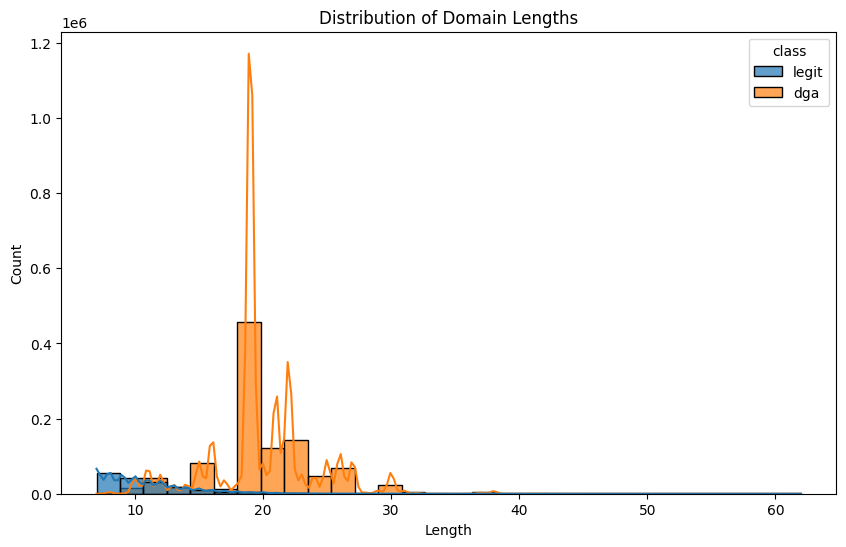

In [11]:
# Distribution of Domain Lengths
#
# This graph shows how common different domain name lengths are for legitimate and malicious (DGA-based) domain names.
#
# The x-axis represents the length of the domain name.
# The y-axis represents the number of domain names (count) of each length.
#
# The blue bars and line represent legitimate domain names, and the orange bars and
# line represent malicious (DGA-based) domain names.
#
# By looking at the shape and position of the bars and lines for each class (legitimate vs. malicious),
# you can see how the length distributions differ.
#
# For example, if the blue bars and line are clustered around certain lengths,
# but the orange bars and line are more spread out, it suggests that legitimate domain names tend to have specific
# common lengths, while malicious domain names have more varied lengths.
#
# This information can help determine if domain length is a useful feature for distinguishing
# between legitimate and malicious domain names in a machine learning model.
#
# Additionally, the presence of any overlapping regions between the blue and orange
# distributions can indicate potential challenges in relying solely on domain length for accurate detection.

plt.figure(figsize=(10, 6))
sns.histplot(data=all_domains, x='length', hue='class', kde=True, bins=30, alpha=0.7)
plt.title('Distribution of Domain Lengths')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

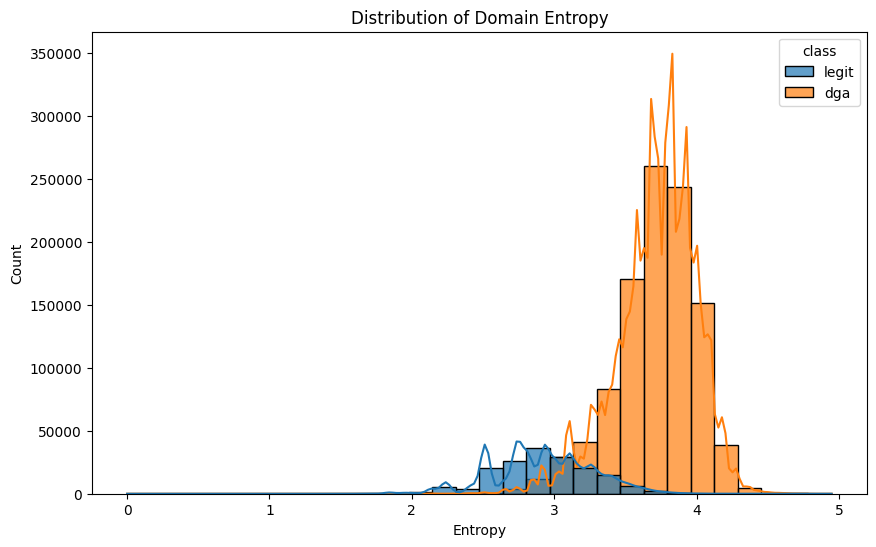

In [12]:
# Distribution of Domain Entropy
#
# This graph shows how common different levels of randomness (entropy) are in legitimate and
# malicious (DGA-based) domain names.
#
# The x-axis represents the entropy (randomness) of the domain name.
# The y-axis represents the number of domain names (count) with each entropy level.
#
# The blue bars and line represent legitimate domain names, and the orange bars and
# line represent malicious (DGA-based) domain names.
#
# By looking at the shape and position of the bars and lines for each class (legitimate vs. malicious),
# you can see how the entropy distributions differ.
#
# For example, if the blue bars and line are clustered around lower entropy values,
# but the orange bars and line are more spread out or skewed towards higher entropy values,
# it suggests that legitimate domain names tend to be less random, while malicious domain names
# are more random and unpredictable.
#
# This information can help determine if domain entropy is a useful feature for distinguishing
# between legitimate and malicious domain names in a machine learning model.
#
# Additionally, the presence of any overlapping regions between the blue and orange distributions
# can indicate potential challenges in relying solely on domain entropy for accurate detection.

plt.figure(figsize=(10, 6))
sns.histplot(data=all_domains, x='entropy', hue='class', kde=True, bins=30, alpha=0.7)
plt.title('Distribution of Domain Entropy')
plt.xlabel('Entropy')
plt.ylabel('Count')
plt.show()

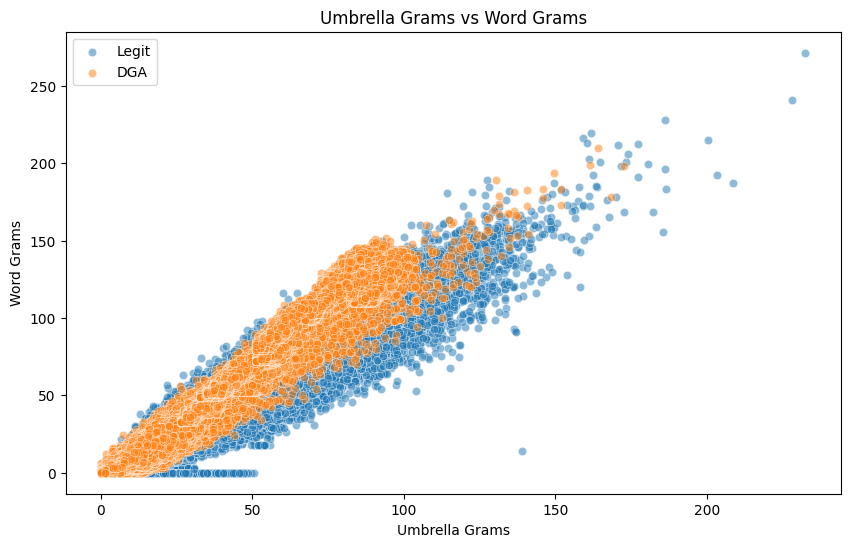

In [13]:
# Relationship between Umbrella Grams and Word Grams
#
# This graph compares two characteristics of domain names:
#   1. How many small pieces of the domain (called n-grams) match with a
#      list of known legitimate domains (x-axis, called "Umbrella Grams")
#   2. How many small pieces of the domain (called n-grams) match with
#      words in a dictionary (y-axis, called "Word Grams")
#
# The blue dots represent legitimate domain names, and the orange dots represent domain names
# generated by malicious software (DGA-based).
#
# If the blue and orange dots form separate clusters, it means that the combination
# of n-gram matches with known legitimate domains and n-gram matches with dictionary words can be
# useful for telling apart legitimate and malicious domain names.
#
# However, if the blue and orange dots overlap a lot, it suggests that additional information
# or more advanced techniques may be needed for accurate detection.
#
# By looking at the patterns and outliers (dots that don't fit the main clusters) in this graph,
# we can better understand the characteristics of legitimate and malicious domain names.
# This understanding can help us develop more effective ways to detect and block malicious domains.

plt.figure(figsize=(10, 6))
sns.scatterplot(data=legit, x='umbrella_grams', y='word_grams', color='#1f77b4', alpha=0.5, label='Legit')
sns.scatterplot(data=dga, x='umbrella_grams', y='word_grams', color='#ff7f0e', alpha=0.5, label='DGA')
plt.title('Umbrella Grams vs Word Grams')
plt.xlabel('Umbrella Grams')
plt.ylabel('Word Grams')
plt.legend()
plt.show()

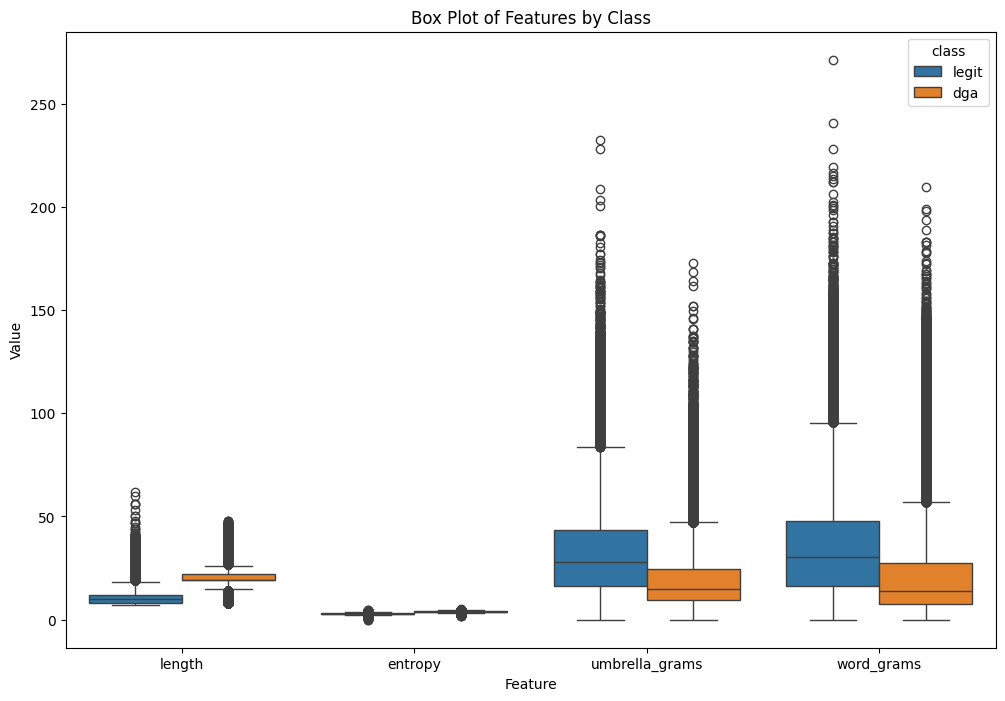

In [14]:
# Box Plot of Features by Class
#
# This graph shows a side-by-side comparison of four different features (characteristics) of domain names, for both legitimate and malicious (DGA-based) domains.
#
# The x-axis lists the four features being compared:
#   1. Length (the number of characters in the domain name)
#   2. Entropy (how random or unpredictable the characters in the domain name are)
#   3. Umbrella Grams (how many small pieces of the domain match with a list of known legitimate domains)
#   4. Word Grams (how many small pieces of the domain match with words in a dictionary)
#
# The y-axis represents the range of values for each feature.
#
# For each feature, there are two boxes (and whiskers) side-by-side:
#   - The blue box represents the distribution of that feature for legitimate domain names
#   - The orange box represents the distribution of that feature for malicious (DGA-based) domain names
#
# By comparing the size, position, and overlap of the blue and orange boxes for each feature,
# you can see how the distributions of those features differ between legitimate and malicious domain names.
#
# Features with little to no overlap between the blue and orange boxes are likely to be more
# useful for distinguishing between legitimate and malicious domains in a machine learning model.
#
# This box plot provides a concise, visual summary of how these four key features relate to
# the two classes of domain names, helping to identify potentially valuable features for DGA detection.

features = ['length', 'entropy', 'umbrella_grams', 'word_grams']
plt.figure(figsize=(12, 8))
sns.boxplot(data=all_domains.melt(id_vars='class', value_vars=features), x='variable', y='value', hue='class')
plt.title('Box Plot of Features by Class')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.show()

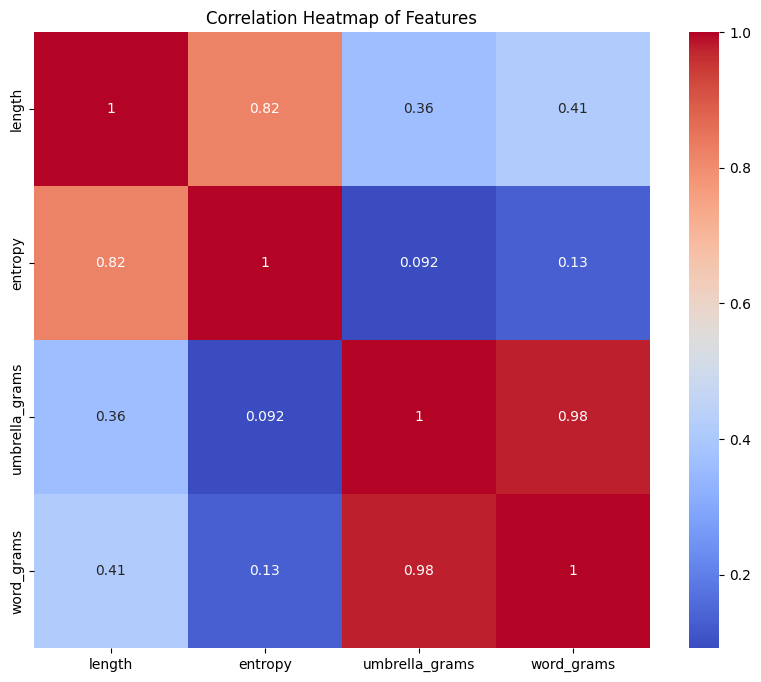

In [15]:
# Correlation Heatmap
#
# This graph is called a correlation heatmap, and it shows how strongly related (or correlated)
# the four features are to each other.
#
# The four features being compared are:
#   1. Length (the number of characters in the domain name)
#   2. Entropy (how random or unpredictable the characters in the domain name are)
#   3. Umbrella Grams (how many small pieces of the domain match with a list of known legitimate domains)
#   4. Word Grams (how many small pieces of the domain match with words in a dictionary)
#
# The heatmap is a square grid, with the features listed along both the rows and columns.
#
# The color in each cell of the grid represents the correlation value between the two corresponding
# features. The darker the red color, the more positively correlated
# the features are (meaning they tend to increase or decrease together).
# The darker the blue color, the more negatively correlated the features are (meaning when one increases,
# the other tends to decrease).
#
# The numerical values in each cell represent the exact correlation value between -1 and 1.
#
# By analyzing this heatmap, you can identify which features are strongly correlated
# with each other (positive or negative) and which features are relatively independent (close to zero correlation).
#
# Highly correlated features may provide redundant information,
# while uncorrelated features could potentially offer complementary information for distinguishing between legitimate and malicious domains in a machine learning model.
#
# This correlation heatmap helps gain insights into the relationships between the features,
# which can inform feature selection and model development strategies for effective DGA detection.

corr = all_domains[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Features')
plt.show()

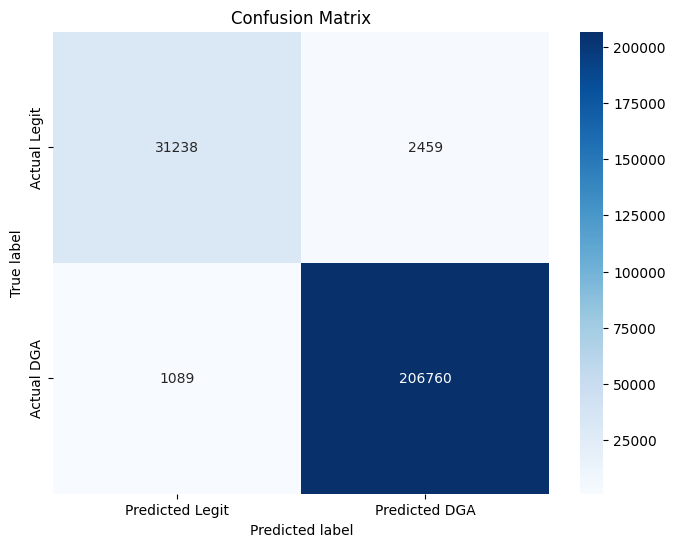

In [16]:
# Confusion Matrix
#
# This graph is called a confusion matrix, and it shows how well a machine learning model is able to classify legitimate and malicious (DGA-based) domain names.
#
# The confusion matrix is a table with two rows and two columns.
#
# The rows represent the true or actual labels of the domain names:
#   - Actual Legit: These are domain names that are actually legitimate
#   - Actual DGA: These are domain names that are actually generated by malicious software (DGA-based)
#
# The columns represent the predicted labels made by the machine learning model:
#   - Predicted Legit: These are domain names that the model predicted to be legitimate
#   - Predicted DGA: These are domain names that the model predicted to be malicious (DGA-based)
#
# The values in each cell of the matrix represent the number of domain names that fall into that category.
#
# Ideally, you want high numbers in the top-left (Actual Legit, Predicted Legit) and bottom-right (Actual DGA, Predicted DGA) cells, which indicate that the model correctly classified legitimate and malicious domains, respectively.
#
# The top-right (Actual Legit, Predicted DGA) and bottom-left (Actual DGA, Predicted Legit) cells represent misclassifications, where the model incorrectly labeled a domain as malicious or legitimate.
#
# By analyzing the values in each cell, you can evaluate the performance of the machine learning model and identify areas for improvement.
#
# A good model should have high values in the top-left and bottom-right cells (correct classifications) and low values in the top-right and bottom-left cells (misclassifications).

cm = confusion_matrix(y_test, y_pred, labels=['legit', 'dga'])
cm_df = pd.DataFrame(cm, index=['Actual Legit', 'Actual DGA'], columns=['Predicted Legit', 'Predicted DGA'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
# Live testing of domain
def test_domain_visual(domain):
    _length = len(domain)
    _entropy = entropy(domain)
    _umbrella_grams = umbrella_counts * umbrella_vc.transform([domain]).T
    _word_grams = dict_counts * dict_vc.transform([domain]).T
    _X = [[_length, _entropy, _umbrella_grams[0], _word_grams[0]]]
    pred = clf.predict(_X)[0]
    
    print(f'Domain: {domain}')
    print(f'Length: {_length}')
    print(f'Entropy: {_entropy}')
    print(f'Umbrella Grams: {_umbrella_grams[0]}')
    print(f'Word Grams: {_word_grams[0]}')
    print(f'Prediction: {pred}')
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    sns.scatterplot(data=legit, x='length', y='umbrella_grams', color='#1f77b4', alpha=0.5, label='Legit')
    sns.scatterplot(data=dga, x='length', y='umbrella_grams', color='#ff7f0e', alpha=0.5, label='DGA')
    plt.scatter(x=_length, y=_umbrella_grams, color='black', marker='*', s=200, label='Test Domain')
    plt.title('Length vs Umbrella Grams')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=legit, x='length', y='entropy', color='#1f77b4', alpha=0.5, label='Legit')
    sns.scatterplot(data=dga, x='length', y='entropy', color='#ff7f0e', alpha=0.5, label='DGA')
    plt.scatter(x=_length, y=_entropy, color='black', marker='*', s=200, label='Test Domain')
    plt.title('Length vs Entropy')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    sns.scatterplot(data=legit, x='word_grams', y='umbrella_grams', color='#1f77b4', alpha=0.5, label='Legit')
    sns.scatterplot(data=dga, x='word_grams', y='umbrella_grams', color='#ff7f0e', alpha=0.5, label='DGA')
    plt.scatter(x=_word_grams, y=_umbrella_grams, color='black', marker='*', s=200, label='Test Domain')
    plt.title('Word Grams vs Umbrella Grams')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    sns.scatterplot(data=legit, x='word_grams', y='entropy', color='#1f77b4', alpha=0.5, label='Legit')
    sns.scatterplot(data=dga, x='word_grams', y='entropy', color='#ff7f0e', alpha=0.5, label='DGA')
    plt.scatter(x=_word_grams, y=_entropy, color='black', marker='*', s=200, label='Test Domain')
    plt.title('Word Grams vs Entropy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Domain: google.com
Length: 10
Entropy: 2.6464393446710153
Umbrella Grams: 23.0521583043468
Word Grams: 18.392437942815256
Prediction: legit


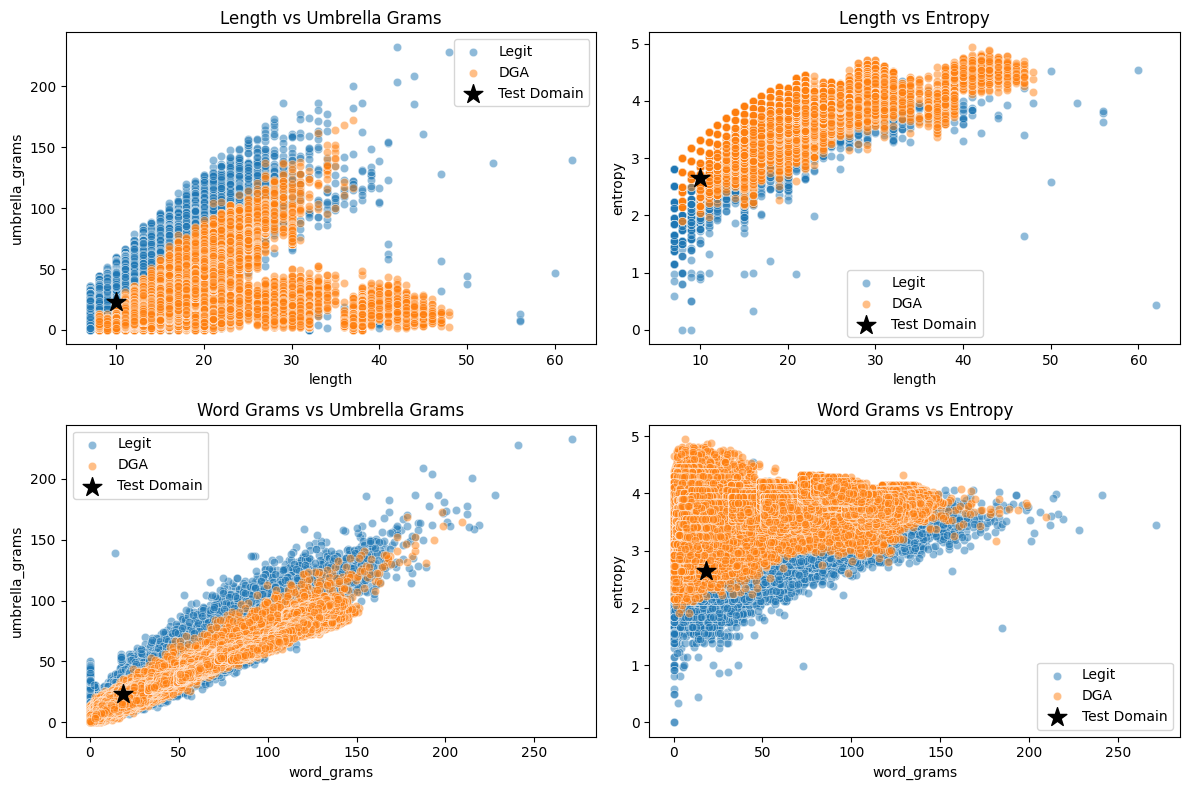

In [18]:
test_domain_visual('google.com')

Domain: um0ocgmpuafx.info
Length: 17
Entropy: 3.6168746059562227
Umbrella Grams: 17.082499687710285
Word Grams: 12.539299283388981
Prediction: dga


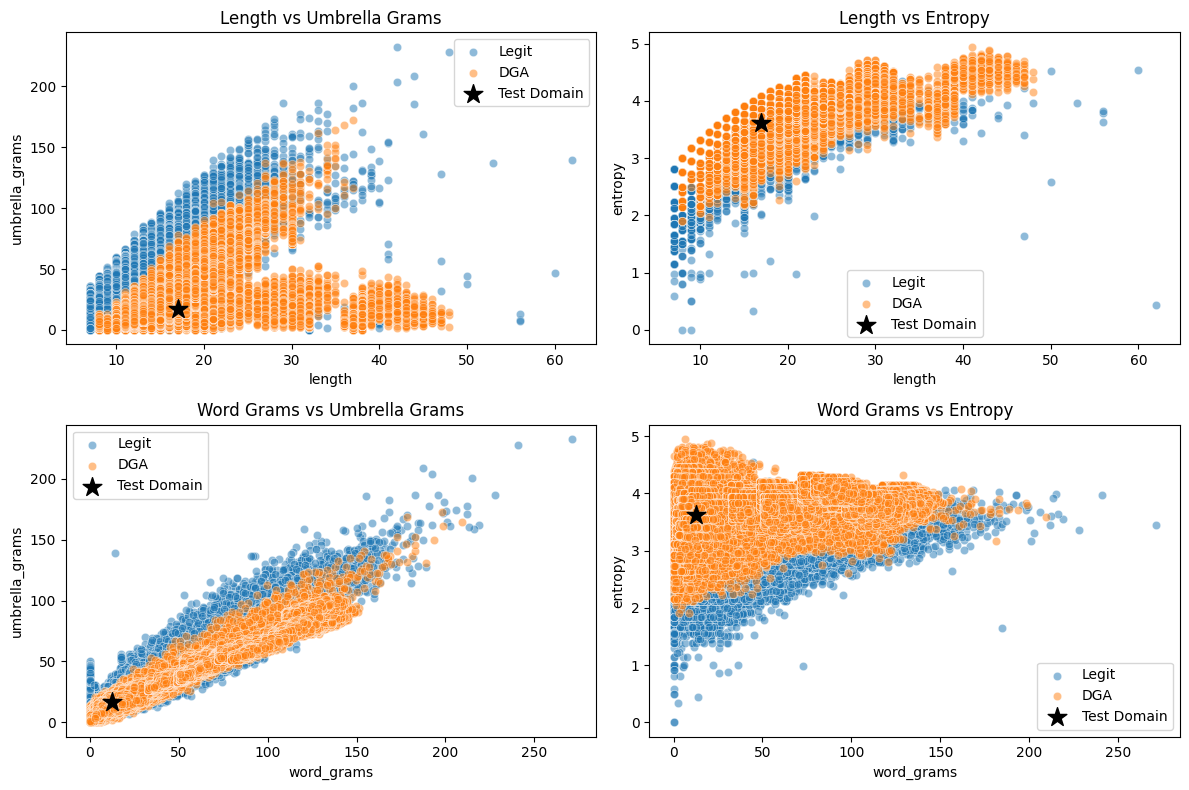

In [19]:
test_domain_visual('um0ocgmpuafx.info')

In [20]:
# This is a simple prediction of legitimate or malicious domain based on the features extracted from the domain name.
# We will be using this type of prediction for an API that will be used to enrich threat intelligence data.
def test_domain(domain):
    _umbrella_match = umbrella_counts * umbrella_vc.transform([domain]).T
    _dict_match = dict_counts * dict_vc.transform([domain]).T
    _X = np.array([len(domain), entropy(domain), _umbrella_match, _dict_match], dtype=object).reshape(1, -1)
    print(f'{domain} : {clf.predict(_X)[0]}')

In [21]:
test_domain('google.com')
test_domain('th1t7jfnf5ch.biz')
test_domain('amazon.com')
test_domain('02z39pr3eq.biz')
test_domain('idd8ud3y3mdset.org')
test_domain('microsoft.com')
test_domain('33uf73md7gd.net')
test_domain('fedu2nd8w.net')
test_domain('n4vdf9wc7fihw.org')
test_domain('facebook.com')
test_domain('tzt4wgd43.info')
test_domain('gqspku9r.com')
test_domain('jackzncgqm5yf.com')
test_domain('azqxi10xm0r.info')
test_domain('instagram.com')
test_domain('um0ocgmpuafx.info')
test_domain('3jjhdaus.net')
test_domain('27end49ppxm99ma.info')
test_domain('pnf8nwccldhh94c.biz')
test_domain('td7sr6xp.info')
test_domain('zlv1wm66vmsoy.org')
test_domain('s12q3yrk7.org')
test_domain('q0r26t3oxz2t.info')
test_domain('easl2sq8cvj9s.info')
test_domain('f1fv3quqe.org')

google.com : legit
th1t7jfnf5ch.biz : dga
amazon.com : legit
02z39pr3eq.biz : dga
idd8ud3y3mdset.org : dga
microsoft.com : legit
33uf73md7gd.net : dga
fedu2nd8w.net : dga
n4vdf9wc7fihw.org : dga
facebook.com : legit
tzt4wgd43.info : dga
gqspku9r.com : dga
jackzncgqm5yf.com : dga
azqxi10xm0r.info : dga
instagram.com : legit
um0ocgmpuafx.info : dga
3jjhdaus.net : dga
27end49ppxm99ma.info : dga
pnf8nwccldhh94c.biz : dga
td7sr6xp.info : dga
zlv1wm66vmsoy.org : dga
s12q3yrk7.org : dga
q0r26t3oxz2t.info : dga
easl2sq8cvj9s.info : dga
f1fv3quqe.org : dga


In [22]:
# Now that we have a trained model and determined that it is reasonably accurate,
# we can save it to disk along with the vectorizers and ngram counts
model_data = {
    'clf': clf,
    'umbrella_vc': umbrella_vc,
    'dict_vc': dict_vc,
    'umbrella_counts': umbrella_counts,
    'dict_counts': dict_counts
}
pickle.dump(model_data, open('dga_model_data.pkl', 'wb'))